## Dataset URL : https://www.kaggle.com/code/kaushalkrishna2000/spam-classification-1/data

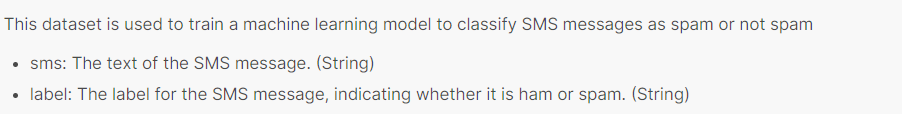

# Package Import

In [1]:
import os
import numpy as np
import multiprocessing as mp
import re
import string
import spacy
import pandas as pd
import spacy
from sklearn.base import TransformerMixin, BaseEstimator
from joblib import Parallel, delayed
from spacy.lang.en.stop_words import STOP_WORDS 
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
nlp = spacy.load(("en_core_web_sm"), disable=["ner","parser"])

# Preprocessing Pipeline

In [3]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, variety="BrE", user_abbrevs={}, n_jobs=1, doit=True):
        """
        Text preprocessing transformer includes steps:
            1. Normal Cleaner
            2. Punctuation removal
            3. Stop words removal
            4. Lemmatization
        
        n_jobs - parallel jobs to run
        """
        self.variety = variety
        self.user_abbrevs = user_abbrevs
        self.n_jobs = n_jobs
        self.doit= doit

    def fit(self, X, y=None):
        return self

    def transform(self, X, *_):
        X_copy = X.copy()

        partitions = 1
        cores = mp.cpu_count()
        if self.n_jobs <= -1:
            partitions = cores
        elif self.n_jobs <= 0:
            return X_copy.apply(self._preprocess_text)
        else:
            partitions = min(self.n_jobs, cores)

        data_split = np.array_split(X_copy, partitions)
        pool = mp.Pool(cores)
        data = pd.concat(pool.map(self._preprocess_part, data_split))
        pool.close()
        pool.join()

        return data

    def _preprocess_part(self, part):
        return part.apply(self._preprocess_text)

    def _preprocess_text(self, text):
        normalized_text =self._cleaner(text,self.doit) if (self.doit) else text
        doc = nlp(normalized_text)
        removed_punct = self._remove_punct(doc)
        removed_stop_words = self._remove_stop_words(removed_punct)
        return self._lemmatize(removed_stop_words)

    def _remove_punct(self, doc):
        return [t for t in doc if t.text not in string.punctuation]

    def _remove_stop_words(self, doc):
        return [t for t in doc if not t.is_stop]
    
    # Remove t.is_alpha for numerical consideration
    def _lemmatize(self, doc):
        return " ".join([t.lemma_ for t in doc])
    
    def _cleaner(self,text,doit):
#         print(text)
        pattern = re.compile(r"[A-Za-z0-9\-]{3,50}")
#         print(re.findall(pattern,text))
        clean = " ".join(re.findall(pattern,text))
        return clean 

# Data preprocess

In [4]:
df=pd.read_csv('/content/train.csv')
df

,sms,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...
5569,This is the 2nd time we have tried 2 contact u...,1
5570,Will ü b going to esplanade fr home?\n,0
5571,"Pity, * was in mood for that. So...any other s...",0
5572,The guy did some bitching but I acted like i'd...,0


In [5]:
t=df.loc[0,'sms']
t

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...\n'

In [6]:
X=df['sms']
y=df['label']

In [7]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [8]:
X.shape,y.shape

((5574,), (5574,))

In [9]:
X_train=(TextPreprocessor(n_jobs=-1).transform(X_train))
X_test=(TextPreprocessor(n_jobs=-1).transform(X_test))

In [10]:
X_train.shape,X_test.shape

((4459,), (1115,))

In [11]:
cov=TfidfVectorizer()
X_train=cov.fit_transform(X_train).toarray()
X_test=cov.transform(X_test).toarray()

In [12]:
X_train.shape,X_test.shape

((4459, 6458), (1115, 6458))

# Model training

In [13]:
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier

In [14]:
clf_1 =LogisticRegressionCV(n_jobs=-1,cv=3,max_iter=2000)
clf_2= SVC()
clf_3 =DecisionTreeClassifier()
clf_4=ExtraTreeClassifier()

clf_5 =RandomForestClassifier(n_jobs=-1)



clf_list=[clf_1,clf_2,clf_3,clf_4,clf_5]

In [15]:
for clf in clf_list: 
    clf.fit(X_train,y_train.values.ravel())

# Model evaluation

In [16]:
for clf in clf_list:
        
    pred=clf.predict(X_test)
    
    print("-"*50)
    
    print(clf.__class__.__name__)
    
    print(classification_report(y_test.values,pred))

--------------------------------------------------
LogisticRegressionCV
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       954
           1       0.97      0.91      0.94       161

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115

--------------------------------------------------
SVC
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       954
           1       0.98      0.88      0.93       161

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115

--------------------------------------------------
DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       954
           1       0.91      0.87   